In [ ]:
"""
To do:

- Train another 5 epochs
- Start transforming data
- Normalize to prevent overfitting

"""

In [ ]:
!pip install datasets

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import models, transforms
from datasets import load_dataset
from torchvision import transforms
from PIL import Image

In [ ]:
def is_grayscale(image):
    return image.mode == 'L'

def custom_collate(batch):
    transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

    batch = [item for item in batch if not is_grayscale(item["image"])]

    images = [transform(item["image"]) for item in batch]
    labels = [item["label"] for item in batch]

    return {"pixel_values": torch.stack(images), "label": torch.tensor(labels)}

In [ ]:
device = torch.device("cuda")

print("Loading dataset...")
dataset = load_dataset("chriamue/bird-species-dataset")

In [ ]:
train_length = len(dataset["train"])
test_length  = len(dataset["test"])
val_length = len(dataset["validation"])

print(f"training samples: {train_length}, validation samples: {val_length}, test samples: {test_length}")

training samples: 84635, validation samples: 2625, test samples: 2625


In [ ]:
train_dataset = Subset(dataset["train"], range(train_length))
test_dataset = Subset(dataset["test"], range(test_length))
val_dataset = Subset(dataset["validation"], range(val_length))

print(f"training samples: {train_length}, validation samples: {val_length}, test samples: {test_length}")

training samples: 84635, validation samples: 2625, test samples: 2625


In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=custom_collate, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=custom_collate)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):

    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=525):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):


        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

model = resnet50()
model = model.to(device)
print("Model created:", model)

In [ ]:
# Initialize an empty list to store bird species
bird_species = []

# Open the text file and read its contents
with open('bird_species.txt', 'r') as file:
    # Read each line in the file
    for line in file:
        # Split the line by whitespace and extract the bird species name
        species_name = line.strip()

        # Append the species name to the bird_species list
        bird_species.append(species_name)

# Print the bird_species list to verify
print(bird_species)


THE LABEL:  CRESTED WOOD PARTRIDGE
Prediction:  CRESTED WOOD PARTRIDGE


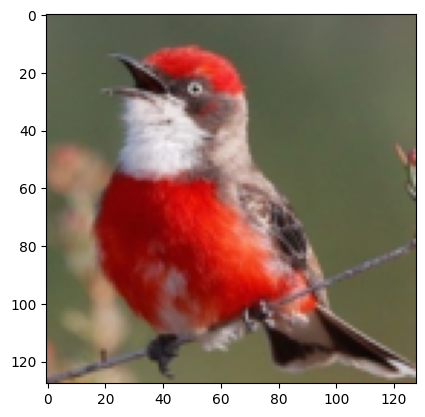

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

i = 0

for batch in val_loader:
  #print(batch["pixel_values"].shape)
  inputs, labels = batch["pixel_values"].to(device), batch["label"].to(device)
  #print(model(inputs))
  for item in range(batch_size):
    image = batch["pixel_values"][item].to(device)
    output = model(image.reshape(1, 3, 128, 128))
    _, predicted = torch.max(output.data, 1)
    image = image.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(image)
    print("THE LABEL: ", bird_species[batch["label"][item].item() - 1])

    print("Prediction: ", bird_species[predicted.item() - 1])
    break
  #   pass
  break
  # pass

In [ ]:
import os
print(os.getcwd())
model.load_state_dict(torch.load("/content/model.pth", map_location=torch.device("cuda")))

In [ ]:
train_losses = []
val_losses = []

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

num_epochs = 5
print(f"Training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, batch in enumerate(train_loader):
        inputs, labels = batch["pixel_values"], batch["label"]

        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = loss_fn(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_losses.append(loss.item())

        print(f"Batch {i}/ {train_length // batch_size}, Loss: {loss.item()}")

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata["pixel_values"], vdata["label"]
            voutputs = model(vinputs.to(device))
            vloss = loss_fn(voutputs, vlabels.to(device))
            val_loss += vloss.item()
            val_losses.append(vloss.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {sum(train_losses)/len(train_losses)}, Validation Loss: {sum(val_losses)/len(val_losses)}")

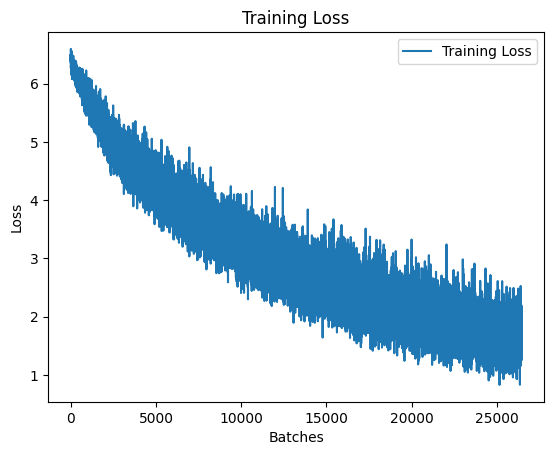

In [ ]:
from matplotlib import pyplot as plt


plt.plot(train_losses, label='Training Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

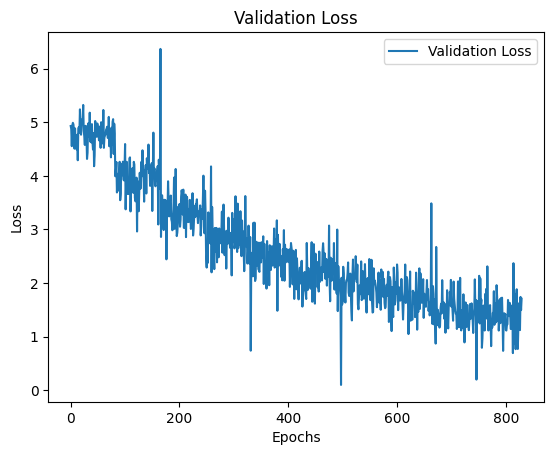

In [ ]:
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

In [ ]:
save_path = "custom_cnn_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch["pixel_values"].to(device), batch["label"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy}")

# First 5 batches 0.39
# Second 5 bathces 0.53
# ----------------------------------------------
# Resnet 50 First 5 batches 0.47
# Resnet 50 Second 5 batches 0.67

Model saved to custom_cnn_model.pth
Validation Accuracy: 0.672


In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

correct = {}
totals = {}

for batch in val_loader:
    inputs, labels = batch["pixel_values"].to(device), batch["label"].to(device)
    for item in range(len(batch["pixel_values"])):
        image = inputs[item]
        output = model(image.unsqueeze(0))  # Add an extra dimension for batch size
        _, predicted = torch.max(output.data, 1)

        label = labels[item].item()

        if predicted == label:
            correct[label] = correct.get(label, 0) + 1
        totals[label] = totals.get(label, 0) + 1

for i in correct.keys():
    print(f"Label {i} accuracy: {correct[i] / totals[i]}")


In [ ]:
for i in sorted(correct.keys()):
  print(f"Label {i} accuracy: {correct[i]/totals[i]}")